CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Homework 4 - Deep Learning - Dog Breed Identification

### *AML71: David Modjeska and Dominic Murphy*

------

# 0. Introduction

The goal of this homework assignment and Kaggle competition is to predict the breeds for a set of dog photos. The dataset originates with ImageNet, as cleaned up by Stanford University, so the foundation for prediction was solid. Our team created two models to address this challenge, as instructed: a feed-forward neural network (FFNN) and a convolutional neural network (CNN).

To prepare for modeling, we pre-processed the images in a number of steps:

0. Scrapped labled data from Animal Planet for aditional training data(External workbook)
1. Resized all images, and converted images for the FFNN to grayscale
2. Encoded the class labels
2. Divided the training data into training and validation subsets
3. Rebalanced the training data subset through image flipping and upsampling
4. Added Rotated Images
5. Reduced the FFNN images through PCA
6. Saved the pre-processed images and related data into pickles for future re-use

On a high level, the FFNN consists of 8 hidden layers with RELU activation, supplemented by dropout and normalization layers. The CNN consists of the well-known VGG16 model, extended and retrained with additional convolutional, dropout, and hidden layers. The FFNN was implemented in TensorFlow for learning purposes, while the CNN was implemented in Keras for classification accuracy. 

Results showed that the CNN model achieved fairly well on Kaggle - scoring in the middle of the field, broadly speaking. Multiclass log loss was approximately 2.8. The FFNN model ran into logistical hurdles, but a wide range of modeling techniques were explored and documented. The narrative for this model captures the details below.

The submission notebooks are cloned to the extent possible for the two models, FFNN and CNN. The shared sections include all pre-processing steps and the metrics structure (and helper functions). The code re-use attained through this discipline paid off in time savings towards the latter half of the assignment. Moreover, team communications benefitted from a shared understanding, vocabulary, and requirements.

# 1. Set up environment

#### Load packages and set display options

In [2]:
import cv2
import math
import numpy as np
import pandas as pd
import os
import re
import random
import seaborn as sns
import tensorflow as tf
import h5py
 
from os import path    
from scipy import ndimage, misc
from six.moves import cPickle as pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tt_split
from sklearn.metrics import hamming_loss, f1_score, roc_curve, auc, log_loss, \
                            classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample, shuffle

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import metrics

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, HTML, Markdown, Image
%matplotlib inline

cache_dir = ''

Using TensorFlow backend.


In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

#### Set global constants for modeling

In [3]:
# input image dimensions
img_rows, img_cols = 128, 128

# smaller batch size means noisier gradient, but more updates per epoch
#Dom: keep high for laptop, lower for AWS
batch_size = 64

# number of iterations over the complete training data
epochs = 10

# how to split the training data among training vs. validation sets
train_ratio = 0.75

# limit the number of images that are processed during project's model exploration phase
n_image_cap = np.inf

# number of principal components to use in data reduction
# this number must be a square in order for sample image display to work 
n_pcs_to_use = 4900

# model_type can be either 'cnn' or 'ffnn'
model_type = 'cnn'

cache_dir = ''

# 2. Load and Explore Class Labels

### Load and clean class labels

In [4]:
labels_data = pd.read_csv( './labels.csv', names = ['kaggle_id', 'breed'], header = 0)
labels_data.breed = labels_data.breed.str.title()

##### Snippet of training data

In [5]:
my_linespace()
my_display_df(labels_data.head())

kaggle_id,breed
000bec180eb18c7604dcecc8fe0dba07,Boston_Bull
001513dfcb2ffafc82cccf4d8bbaba97,Dingo
001cdf01b096e06d78e9e5112d419397,Pekinese
00214f311d5d2247d5dfe4fe24b2303d,Bluetick
0021f9ceb3235effd7fcde7f7538ed62,Golden_Retriever


#### Sample of class labels

In [6]:
class_labels = labels_data.breed.unique()
print()
print(*class_labels[:20], sep = ', ')


Boston_Bull, Dingo, Pekinese, Bluetick, Golden_Retriever, Bedlington_Terrier, Borzoi, Basenji, Scottish_Deerhound, Shetland_Sheepdog, Walker_Hound, Maltese_Dog, Norfolk_Terrier, African_Hunting_Dog, Wire-Haired_Fox_Terrier, Redbone, Lakeland_Terrier, Boxer, Doberman, Otterhound


#### Summary of image counts by breed

In the summary statistics, histogram, and bar chart below, the most interesting thing to notice is the class is the class imbalance: class labels per breed span a range from 66 through 120, with a mean around 85. Clearly some sort of upsampling or rebalancing is required. Our approach will be explained below in connection with image flipping.

In [7]:
counts = labels_data.breed.value_counts()
counts_df = pd.DataFrame({'breed':counts.index, 'count':counts}).reset_index(drop = True)
counts_df.describe()

,count
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


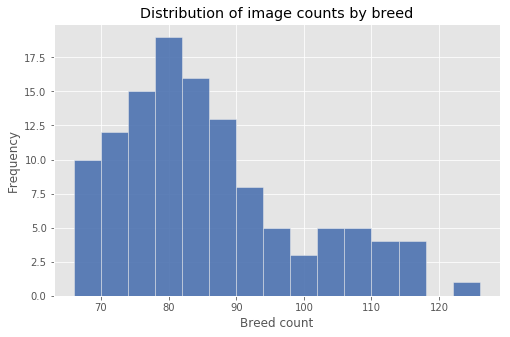

In [8]:
print()
plt.figure(figsize = (8, 5))
sns.distplot(a = counts_df['count'], bins = 15, hist = True, kde = False, 
             hist_kws={"alpha": 0.9})
plt.xlabel('Breed count')
plt.ylabel('Frequency')
plt.title('Distribution of image counts by breed')
plt.show()

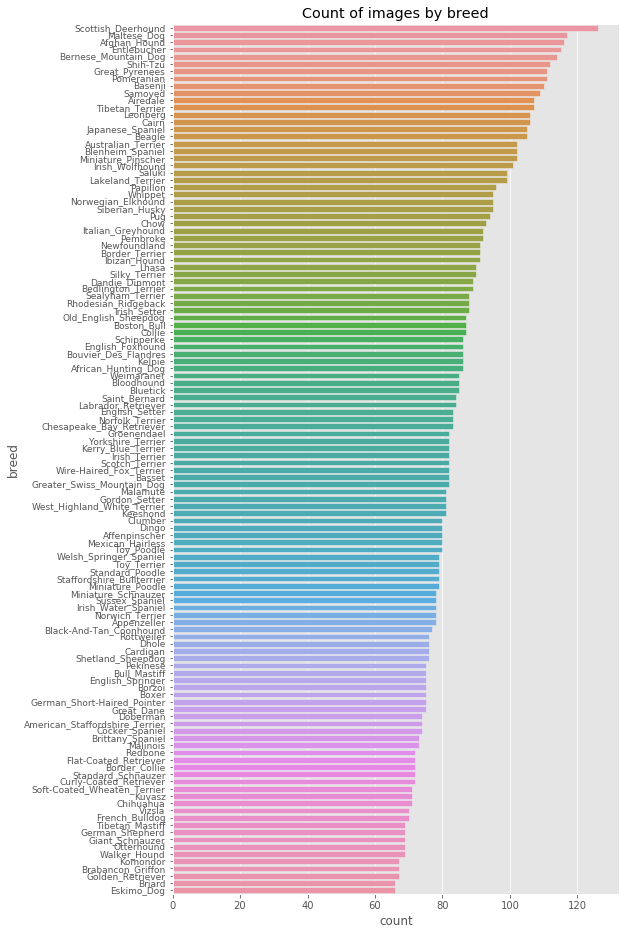

In [9]:
print()
plt.figure(figsize = (8, 16))
ax = plt.subplot(1, 1, 1)
sns.barplot(y = 'breed', x = 'count', data = counts_df)
plt.title('Count of images by breed')
ax.set_yticklabels(labels = counts_df.breed, fontsize=9)
plt.show()

# 3. Load and Preprocess Images

#### Load and resize images

The training or testing images are loaded from disk in one large code loop per set, in the code below. After loading each image, it is resized to 128 x 128 pixels and reshaped for modeling. Images for the FFNN are also converted to grayscale, as a kind of 'smart' flattening to one layer. Each image is added to a master list after this processing, and each image's ID is taken from the filename and inserted into a parallel list. This ID list will be used to synchronize the class labels data with the loaded imagery. Finally, each image is normalized through division by 255, in order to ensure that all data values lie between 0.0 and 1.0.

In [10]:
def load_process_images(image_dir):
    is_color = (model_type == 'cnn')
    
    #----- prepare for loading
    
    images = []
    image_ids = []

    image_dir = './' + image_dir + '/'
    
    image_filenames = os.listdir(image_dir)
    if (image_dir is 'train') and (labels_data.shape[0] != len(image_filenames)):
        print("Number of training labels doesn't match number of training images on disk")

    #----- load and resize images
    
    n_images = min(n_image_cap, len(image_filenames))
    for i in range(n_images):

        # get image and id from disk
        filename = image_filenames[i]
        image = cv2.imread(image_dir + filename)
        id = re.sub('.jpg', '', filename)

        image = cv2.resize(image, (img_rows, img_cols))
        if is_color:
            image = np.array(image).reshape((3, img_rows, img_cols))            
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            

        # add image and id to list
        images.append([image])
        image_ids.append(id)

    #----- collect the image list into an array

    x = np.array(images) 
    if is_color: # add new dimension to array
        x = x[:, 0, :, :]
    images = None
    
    if is_color: # assumes TensorFlow as backend, so scalar for # dimensions is last
        x = x.reshape(x.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)
    else:
        x = x.reshape(x.shape[0], img_rows, img_cols) 
        input_shape = (img_rows, img_cols) 
        
    #----- center and normalize images
    
    # normalize image values to [0,1] (Keras sample code doesn't center)
    x = x.astype('float32')
    x /= 255 # standardization

    # display status
    print()
    print('After loading ' + image_dir + ' directory:')
    print('\tLoaded', len(image_ids), 'images from disk')
    print('\tx shape:', x.shape)
    print('\t' + str(x.shape[0]) + ' samples processed')        
        
    return(x, image_ids, input_shape)

In [11]:
def add_scraped_images(x_train, y_train):

    #load images scrapped from Animal planet
    x_scraped, labels_data , _ = load_process_images(image_dir = 'scraped')
    
    y_scraped = encode_y_scraped(labels_data, label_encoder, one_hot_encoder )
    
    x_train = np.vstack((x_train, x_scraped))
    y_train = np.vstack((y_train, y_scraped))

    x_train, y_train = shuffle(x_train, y_train, random_state = 0)
    
    return x_train, y_train;

#### Encode y

The class labels for the training data are loaded separately. These labels are then inner-joined with the already-loaded images, using image ID as the join key. After this merge, class labels are encoded as digits and then one-hot encoded for modeling.

In [12]:
# construct y for classification (TO DO: verify synchronization of labels with images)
def encode_y(x_ids, labels_data):
    x_ids_df = pd.DataFrame(x_ids, columns = ['id'])
    y_0 = pd.merge(left = x_ids_df, right = labels_data , left_on = 'id', right_on = 'kaggle_id')
    y_0 = y_0.breed.values 

    label_encoder = LabelEncoder()
    label_encoder.fit(y_0)
    y_1 = label_encoder.transform(y_0).reshape(-1, 1)

    one_hot_encoder = OneHotEncoder(sparse = False)
    one_hot_encoder.fit(y_1)
    y = one_hot_encoder.transform(y_1)

    num_labels = y.shape[1]
    
    return(y, label_encoder, one_hot_encoder, num_labels)


def encode_y_scraped(labels_data, label_encoder, one_hot_encoder ):
    for i in range(len(labels_data)):
        labels_data[i] = re.sub('_[0-9]$', '', labels_data[i])
        
    y_0 = np.array(labels_data)
    
    y_1 = label_encoder.transform(labels_data).reshape(-1, 1)
    y   = one_hot_encoder.transform(y_1)
    
    return(y)

#### Split training data into train and validation sets

In [13]:
# split training x and y into train and validation sets
def split_my_training_data(x, y):
    x_train, x_valid, y_train, y_valid, = tt_split(x, y, train_size = train_ratio, test_size = 1.0 - train_ratio, 
                                                   shuffle = True)

    print()
    print('After splitting training data:')
    print()
    print('\tx_train shape: ' + str(x_train.shape))
    print('\tx_valid shape: ' + str(x_valid.shape))

    print()
    print('\ty_train shape: ' + str(y_train.shape))
    print('\ty_valid shape: ' + str(y_valid.shape))
    
    return(x_train, x_valid, y_train, y_valid)

#### Rebalance the classes with up-sampling from flipped images

In order to address the two-to-one class imabalance, we upsampled the minority classes to the size of the majority class through image flipping. Color images were flipped using the opencv package, while B/W images were flipped using NumPy. The resulting images were appended to the training data, along with the relevant class labels. We should note that neither the validation data nor the testing data were touched during this upsampling process.

In [14]:
#move from one hot encoding back to single column per row with class index number
def one_hot_decode(y):
    return(np.argmax(y, axis = -1))

In [15]:
# adds flipped images to minority classes to balance the training set
# Example: x_train, y_train = class_balance_with_image_flip( x_train, y_train )
# TO DO: for very unbalanced classes, oversample using both flipped and original images
def class_balance_with_image_flip( x_train, y_train, is_color = True):
    
    #move from one hot encoding back to single column per row with class index number
    y_train_decode = one_hot_decode(y_train)

    #get counts by class index
    counts = np.unique(y_train_decode, return_counts=True)

    #find number of images are in the majority class
    max_class_count = np.max(counts[1])

    flipped_x_list = []
    flipped_y_idx_list = []

    for i_class in counts[0]:

        #get original images for the class
        class_imgs = x_train[np.where(y_train_decode == i_class )]
        
        #find the number of images we needed to balance the class
        n_original = len(class_imgs) 
        n_target = max_class_count - n_original
        
        #Flip the original images to create new images
        i_row = 0
        for i in range(n_target):
            
            #horizontaly flip the original image              
            if is_color :
                image = cv2.flip( class_imgs[i_row], 1 )   
                image = np.array(image).reshape((img_rows, img_cols, 3))
            else: #BW   
                image = np.flip(class_imgs[i_row], axis = 1)
                image = np.array(image).reshape((img_rows, img_cols))

            flipped_x_list.append(image)   
            flipped_y_idx_list.append(i_class)

            #loop back to first class image if we have exceed the number of original images
            i_row += 1
            if i_row >= n_original:
                i_row = 0

    if len(flipped_x_list) > 0:           
        
        #gather flipped images
        x_flipped = np.array(flipped_x_list) 

        y_flipped_decode = np.array(flipped_y_idx_list) # cast list to array
        y_flipped = one_hot_encoder.transform(y_flipped_decode.reshape(-1, 1) )  

        #append to end of training set
        y_train = np.concatenate((y_train, y_flipped), axis=0)         
        x_train = np.concatenate((x_train, x_flipped), axis=0)
       
        #reshuffle to mix the original and flipped images
        x_train, y_train = shuffle(x_train, y_train, random_state = 0)
   
    print()
    print (len(flipped_x_list),' image(s) flipped and added')
    return(x_train, y_train);

In [16]:
# adds flipped images to minority classes to balance the training set
# Example: x_train, y_train = class_balance_with_image_flip( x_train, y_train )
# TO DO: for very unbalanced classes, oversample using both flipped and original images
def add_shaprened_images( x_train, y_train, is_color = True):
    
    #move from one hot encoding back to single column per row with class index number
    y_train_decode = one_hot_decode(y_train)

    #get counts by class index
    counts = np.unique(y_train_decode, return_counts=True)

    #find number of images are in the majority class
    max_class_count = np.max(counts[1])

    flipped_x_list = []
    flipped_y_idx_list = []

    for i_class in counts[0]:

        #get original images for the class
        class_imgs = x_train[np.where(y_train_decode == i_class )]
        
        #find the number of images we needed to balance the class
        n_original = len(class_imgs) 
        n_target = max_class_count - n_original
        
        #Flip the original images to create new images
        i_row = 0
        for i in range(n_target):
            
            #horizontaly flip the original image              
            if is_color :
                image = cv2.flip( class_imgs[i_row], 1 )   
                image = np.array(image).reshape((img_rows, img_cols, 3))
            else: #BW   
                image = np.flip(class_imgs[i_row], axis = 1)
                image = np.array(image).reshape((img_rows, img_cols))

            flipped_x_list.append(image)   
            flipped_y_idx_list.append(i_class)

            #loop back to first class image if we have exceed the number of original images
            i_row += 1
            if i_row >= n_original:
                i_row = 0

    if len(flipped_x_list) > 0:           
        
        #gather flipped images
        x_flipped = np.array(flipped_x_list) 

        y_flipped_decode = np.array(flipped_y_idx_list) # cast list to array
        y_flipped = one_hot_encoder.transform(y_flipped_decode.reshape(-1, 1) )  

        #append to end of training set
        y_train = np.concatenate((y_train, y_flipped), axis=0)         
        x_train = np.concatenate((x_train, x_flipped), axis=0)
       
        #reshuffle to mix the original and flipped images
        x_train, y_train = shuffle(x_train, y_train, random_state = 0)
   
    print()
    print (len(flipped_x_list),' image(s) flipped and added')
    return(x_train, y_train);

#### Reduce FFNN training data using PCA

Because the B/W images can be linearized for efficient modeling, it makes sense to apply PCA for both data reduction and a sort of regularization. Accordingly, a number of principal components was found that explained approximately 99% of the original variance, while reducing the actual data size by approximately 75%. (The scree plot below shows the tradeoff between number of principal components and variance explained.) For assignment purposes, a major benefit of applying PCA was the improvement in model training performance, which allowed additional experimentation during the time available.

In [17]:
### visualize and choose number of principal components to use
def viz_pca(pca_attribs, n_pcs_to_use):
    n_pcs_to_use = min(n_pcs_to_use, len(x_train) - 1)

    components = pca_attribs[0]
    explained_variance_ratio = pca_attribs[1]
    
    cum_var_exp = 100.0 * explained_variance_ratio.cumsum()
    plot_n_components = round(components.shape[0])

    # plot percentage of variance not explained
    print()
    fig = plt.figure(figsize = (8, 4))
    plt.plot(100.0 - cum_var_exp[:plot_n_components])
    plt.xticks(range(0, plot_n_components, 500))
    plt.xlabel('Number of principal components')
    plt.ylabel('% of variance not explained')
    plt.title('Scree plot for PCA')
    plt.show()

    # print cumlative percentage of variance explained
    my_linespace()
    my_display('Percentage of variance explained by ' + 
          str(n_pcs_to_use) + 
          ' principal components: ' +
          str(round(cum_var_exp[n_pcs_to_use - 1], 2)) +
          '%')
    my_linespace()

In [18]:
def reduce_image_data(x_train, x_valid, x_test):
    
    # flatten image arrays
    x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols) 
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows * img_cols)   
    x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols) 

    pca = PCA(copy = True, random_state = 0, n_components = n_pcs_to_use, 
              svd_solver = 'full')     
    pca.fit(np.vstack([x_train, x_valid]))

    # transform using PCA
    x_train = pca.transform(x_train)
    x_valid = pca.transform(x_valid)
    x_test = pca.transform(x_test)    

    input_shape = [n_pcs_to_use]

    # display shapes of transformed data
    print()
    print('After PCA:')
    print('\tx_train shape: ' + str(x_train.shape))
    print('\tx_valid shape: ' + str(x_valid.shape))  
    print('\tx_test shape: ' + str(x_test.shape))      
      
    return(x_train, x_valid, x_test, pca)

#### Save/load preprocessed images as pickle files

To save time during modeling runs and experiments, we saved all pre-processed data to pickle files for easy reloading during future sessions. Care was needed to capture image data accurately and completely, of course, as well as to serialize the necessary parts of encoding and data reduction functions. The resuting pickle files for color images were large enough to warrant being split into two parts. (As it turns out, the S3 storage of AWS was ideal for this purpose.)

In [19]:
# save a prepared pickle file
def save_pickle(pickle_filename, save):
    try:
        f = open(pickle_filename, 'wb')
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_filename, ':', e)
        raise

    statinfo = os.stat(pickle_filename)
    print()
    print('Size of pickle file', pickle_filename, ':', statinfo.st_size)

In [20]:
# prepare and save a new pickle file
def prep_and_save_pickle_file(pickle_filename, x, y, x_ids, data_source, pca = None):    

    # prep data structure to save
    if pca != None:
        pca_explained_variance_ratio = pca.explained_variance_ratio_
        one_hot_encoder.active_features_
        label_encoder.classes_
    
    p1_num = math.ceil(len(x)/2)
    
    save = {
            'x1': x[0:p1_num],
            'x_ids': x_ids,
            'y1': y[0:p1_num]                                             if y is not None else None,
            'input_shape': input_shape,
            'pca_components': pca.components_                             if pca is not None else None,
            'pca_mean'      : pca.mean_                                   if pca is not None else None,
            'pca_explained_variance_ratio': pca.explained_variance_ratio_ if pca is not None else None,
            'encoder_labels': one_hot_encoder.active_features_            if one_hot_encoder is not None else None,
            'encoder_names' : label_encoder.classes_                      if label_encoder is not None else None
            }
    
    # save images to pickle file for future sessions    
    save_pickle(pickle_filename, save)
    
    save = {
            'x2': x[p1_num:] ,
            'y2': y[p1_num:]                                              if y is not None else None,
            }
    
    # save images to pickle file for future sessions    
    save_pickle('2_' + pickle_filename, save)
    
    print()        
    print ('Saved pickle file:', data_source, input_shape[0]) 



In [21]:
# load an existing pickle file
def load_pickle_file(pickle_filename):

    # fill data structure from loaded pickle
    with open(pickle_filename, 'rb') as f:
        save = pickle.load(f)
        x1 = save['x1']
        x_ids = save['x_ids']
        y1 = save['y1']
        input_shape = save['input_shape'],
        pca_components = save['pca_components'],
        pca_mean = save['pca_mean'],
        pca_explained_variance_ratio = save['pca_explained_variance_ratio'],
        encoder_labels = save['encoder_labels'],
        encoder_names = save['encoder_names']
        
    # fill data structure from loaded pickle
    with open('2_' + pickle_filename, 'rb') as f:
        save = pickle.load(f)
        x2 = save['x2']
        y2 = save['y2']
    
    x = np.concatenate((x1,x2), axis=0)
    y = np.concatenate((y1,y2), axis=0) if y1 is not None else None
        
    # adjust data types after pickling
    input_shape = input_shape[0]
    pca_components = pca_components[0]   
    pca_explained_variance_ratio = np.array(pca_explained_variance_ratio)
    encoder_labels = np.array(encoder_labels).T.flatten()
    
    print()
    print ('Loaded pickle file:', pickle_filename, input_shape[0])   
    
    pca_attribs = [pca_components, pca_explained_variance_ratio, pca_mean]
    return(x, y, x_ids, input_shape, pca_attribs, encoder_labels, encoder_names)

#### Top-level script to preprocess all data

The top-level script below runs all pre-processing functions as needed, according to situation. 

In [22]:
prep_filename = lambda data_source: \
    'HW4_data_' + data_source + '_' + str(img_rows) + '_' + model_type + '.pickle'
    
train_filename = prep_filename('train')
valid_filename = prep_filename('valid')
test_filename = prep_filename('test')

# pickle files don't exist yet, so preprocess data and create them
if not path.exists(train_filename) \
    or not path.exists(valid_filename) \
    or not path.exists (test_filename):

    # load and process images
    x, x_ids, input_shape = load_process_images('train')
    x_test, x_ids_test, input_shape = load_process_images('test')    
    
    # encode y
    y, label_encoder, one_hot_encoder, num_labels = encode_y(x_ids, labels_data)   
    
    # split training data
    x_train, x_valid, y_train, y_valid = split_my_training_data(x, y)
    x = y = None # free memory
    
    #load images scraped form Animal planet
    x_train, y_train = add_scraped_images(x_train, y_train)
    
    # rebalance classes with upsampling from flipped images
    is_color = (model_type == 'cnn')
    x_train, y_train = class_balance_with_image_flip(x_train, y_train, is_color)
    
    # reduce image data
    pca = None
    if not is_color:
        x_train, x_valid, x_test, pca = reduce_image_data(x_train, x_valid, x_test)
        pca_attribs = [pca.components_, pca.explained_variance_ratio_, pca.mean_]
        
    encoder_labels = one_hot_encoder.active_features_
    encoder_names = label_encoder.classes_
    
    # save pickle files
    prep_and_save_pickle_file(train_filename, x_train, y_train, None       , 'train', pca)
    prep_and_save_pickle_file(valid_filename, x_valid, y_valid, None       , 'valid', pca)
    prep_and_save_pickle_file(test_filename , x_test , None   , x_ids_test , 'train', pca)
    
# pickle files already exist, to load them    
else:
    x_train, y_train, _, input_shape, pca_attribs, encoder_labels, encoder_names = load_pickle_file(train_filename)
    x_valid, y_valid, _         , _, _, _, _ = load_pickle_file(valid_filename)
    x_test , y_test , x_ids_test, _, _, _, _ = load_pickle_file(test_filename)
    
    num_labels = y_train.shape[1]


Loaded pickle file: HW4_data_train_128_cnn.pickle 128

Loaded pickle file: HW4_data_valid_128_cnn.pickle 128

Loaded pickle file: HW4_data_test_128_cnn.pickle 128


In [23]:
def add_rotated_images(x_train, y_train):
    degrees = 5
    rotated_x_list = []
    for i in range(x_train.shape[0]):
        
        M = cv2.getRotationMatrix2D((img_cols/2,img_rows/2),degrees,1)
        image = cv2.warpAffine(x_train[i],M,(img_cols,img_rows))
        
        rotated_x_list.append(image)          
    x_rotated = np.array(rotated_x_list)      
    x_train = np.vstack((x_train, x_rotated))

    y_train = np.vstack((y_train, y_train)) 

    x_train, y_train = shuffle(x_train, y_train, random_state = 0)

    print()
    print (len(rotated_x_list),' image(s) rotated and added')

    return(x_train, y_train);

x_train, y_train = add_rotated_images(x_train, y_train)


11040  image(s) rotated and added


In [24]:
# image_dir = 'train/'
# image_filenames = os.listdir(image_dir)
# for i in range(1):
#     filename = image_filenames[i]
#     image = cv2.imread(image_dir + filename)
#     image = cv2.resize(image, (img_rows, img_cols))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)       
# image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 

# plt.imshow(image)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

# image2 = sharpen_image(image)
# plt.imshow(image2)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

# image3 = rotate_image(image)
# plt.imshow(image3)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

# image4 = warp_image(image)
# plt.imshow(image4)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

In [25]:
if model_type is 'ffnn':
    viz_pca(pca_attribs, n_pcs_to_use)

#### Display sample images

After such extensive pre-processing, it's essential to validate image quality and label pairing through visual inspection. While exhaustive inspection is impossible, the code below is set up to allow random inspection of twelve images and labels at a time from each of the training or validation set, as well as twelve images at a time from the testing set. The B/W images must be reconstituted from PCA-reduced form (as well as renormalized) for display. Inspection results during multiple runs for all data sets showed no obvious problems, so we proceeded with modeling on this foundation.

In [26]:
def renormalize_image(x):
    x_adjust = np.amin(x)
    if x_adjust < 0:
        x += -x_adjust
        x_range = np.amax(x) - np.amin(x)
        x /= x_range

In [27]:
num_rows = 3
num_cols = 4
num_images_to_display = num_rows * num_cols

# get sample images from training data
x_display, x_display_labels_0 = resample(x_train, y_train, replace = False, n_samples = num_rows * num_cols)
x_display_labels = encoder_names[one_hot_decode(x_display_labels_0)]

# prepare b/w images for display
if model_type is not 'cnn':
    pca_components = pca_attribs[0]
    pca_mean = pca_attribs[2]
    
    x_display = np.dot(x_display, pca_components) + pca_mean
    renormalize_image(x_display)               
    x_display = x_display.reshape(x_display.shape[0], img_rows, img_cols)

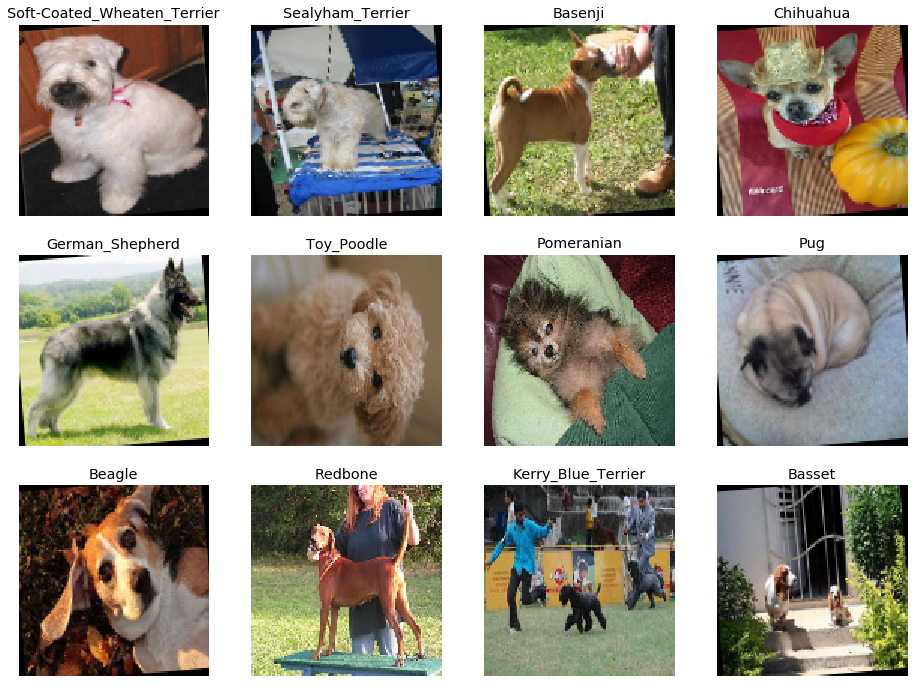

In [28]:
# code adapted from:
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html

print()
plt.figure(figsize = (16, 12))

for i in range(num_images_to_display):
    plt.subplot(num_rows, num_images_to_display/num_rows, i + 1)
    
    convert_spec = cv2.COLOR_BGR2RGB if model_type is 'cnn' else cv2.COLOR_GRAY2RGB
    image = cv2.cvtColor(x_display[i], convert_spec) 
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(x_display_labels[i])
    
plt.show()

## 4. Train FFNN Model in TensorFlown (Please see other notebook)

#### Define helper functions

In [29]:
def categorical_accuracy(y_true, y_pred_proba):
    return(np.mean(np.equal(np.argmax(y_true, axis = -1), 
                            np.argmax(y_pred_proba, axis = -1))))

## 5. Train CNN Model in Keras

Our CNN model is based on the VGG-16 network. Significantly, the basic network uses pre-trained weights, leveraging several months of training by the original creators. To adapt the network to our current context and data, we replaced the top three layers and also added three additional layers for finalization. This approach provided beneficial learning transfer, of course, to save time. Approximately 10,000 images were sufficient to (re)train the top six layers of the trained network with fair success. We suplimented the training set with data scraped form Animal Planet's <a href = "http://www.animalplanet.com/breed-selector/dog-breeds/all-breeds-a-z.html">Dog Breed Guide</a>. We were able to match 117 of 120 breeds in the Stanford Dog image dataset.

We used the Adam algorithm for optimization during training. The initial Adam parameters were inspired by the paper <a href="https://arxiv.org/pdf/1412.6980v8.pdf">Adam: A Method for Stochastic Optimization, Kingma, Lei Ba, 2015</a>. Although the pretrained model is mature, we selected an agressive initial learning rate of 0.1, given that the learning scheduler would automatically reduce this learning rate over time. Applying Kingma's recommendations, we scheduled the learning rate decay as (initial learning_rate) / sqrt(epochs). We explored the epsilon parameter in the range (0.1 , 1), as other people tuning VGG-16 have had sucsess in that range. 

A smaller image size of 128x128 (rather than the default of 244x244) was chosen to accommodate memory, CPU, and GPU constraints on AWS EC2 with available p2.xlarge instances. The final two dense layers where reduced from VGG’s 4,096 channels to 1024 to reflect this smaller image size. In addition, the output layer was trimmed from 1000 features to 120 to reflect the number of dog breeds in this dataset.  (Full details of our deep-learning hyperparameters are shown below.)

An additional advantage of using the VGG-16 model, was that we were able to leverage the power of a pretrained model while at the same time learning how to adapt and apply to a new context.

Exploration path
with controling the learning rate we explored a schedualed decay (initial learning_rate) / sqrt(epochs) and a reactive reduction on learning pleateau. The schedual decay outperformed the rective method wich was unexpected.

The we explored inital learning rates between .001 and .2. we found that the learning rate close to .001 was most successful.

We found epsilon had a major impact on our results. We achieved good results between .1 and .5. outside of this range the impact was a dramatic drop in performance.

We invested time upfront in the procrossing phase not to contaminate our validation data. This proved useful as the loss rate on our validation set was consistantly relective of the lost rates on kaggle using the testing set.

During the learning the epoch with the best results against validation was exported as our "best model". In effect this selected the optimal point before the model begain to overfit. The best model was used for all predictions. 

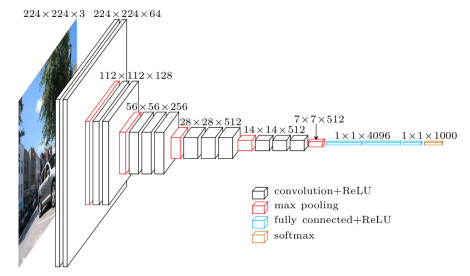

In [4]:
Image('./VGG16.png')

#### Adam Configuration Parameters

<table>
 <tr>
  <td>Param</td> 
  <td>Value</td>
  <td style="text-align:left">Comment</td> 
 </tr>

 <tr><td>alpha<br>/learning_rate<br>/step size</td> <td>.001</td> <td style="text-align:left">The proportion that weights are updated. Consider moving up to .3 for faster initial learning</td></tr>
 <tr><td>beta_1</td> <td>.9</td>   <td style="text-align:left">Set close to 1. <br> The exponential decay rate for the first moment estimates</td></tr>
 <tr><td>beta_2</td> <td>.999</td> <td style="text-align:left">Set close to 1. <br>The exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).</td></tr>
 <tr><td>epsilon</td> <td>.1</td> <td style="text-align:left">
 Image net is a mature model and past explorations suggest a current good choice is 1.0 or 0.1.<br> 
 The default value of epsilon is 1e-8 is largely set to prevent divide by zero errors.</td>
 </tr> 
 <tr><td>decay</td> <td>reduces</td>   <td style="text-align:left">decay = learning_rate / (epochs+1)^.5</td></tr>
</table>

ref: <a href="https://arxiv.org/pdf/1412.6980v8.pdf">Adam: A Method for Stochastic Optimization, Kingma, Lei Ba, 2015</a>

#### Compile model

In [31]:
#### Create model shell for cnn
def VGG_16():
    #load vgg16 without the 3 fully-connected layers at the top of the network
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)

    # set all other layers from the pretained model to non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    # create new classification layers for our classes ---
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    #x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    #x = BatchNormalization()(x)
    upper_model = Dense(num_labels, activation = 'softmax', )(x)
    
    #Place our classification layer on top of the existing model
    model = keras.models.Model(inputs = base_model.input, outputs = upper_model)

    model.summary()
    return model;

In [32]:
epochs = 200

if model_type is 'cnn':
    model_filename  = cache_dir + 'best_model_cnn.hdf5'
    pickle_filename = cache_dir + 'history.pickle' 
    
    if path.exists(model_filename):
        model = load_model(model_filename)
        
        #load model history
        if path.exists(pickle_filename):
            training_history = pickle.load(open(pickle_filename, 'rb'))['training_history']
        
        model_loaded = True
    else:
        model_loaded = False
        model = VGG_16()
    
        adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = .01, decay = 0) #See callbacks for decay
        model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    print ('cnn model loaded: ', model_loaded)   

cnn model loaded:  True


#### Train model and score with validation data

In [33]:
if model_type is 'cnn' and model_loaded == False:
    
    def step_decay(epoch):
        initial_lrate = 0.001
        lrate = initial_lrate / math.pow(epoch + 1, .5)
        return lrate;

    reduce_lr = LearningRateScheduler(step_decay)
    
#    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
#                                  patience = 10, min_lr = 0.000001)

    early_stop = EarlyStopping (  monitor   = 'val_loss'
                                , min_delta = .0001
                                , patience  = 30
                                , verbose   = 0
                                , mode      = 'auto')

    csv_logger = CSVLogger('training.log')

    model_checkpoint = ModelCheckpoint(filepath = model_filename, monitor = 'val_loss', 
                                       verbose = 0, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', period = 1)

    history = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        callbacks = [reduce_lr, early_stop, csv_logger, model_checkpoint],
                        verbose = 1,
                        validation_data = (x_valid, y_valid))
    
    #save model training history to pickle
    training_history = history.history
    save_pickle(pickle_filename, {'training_history': training_history} )

In [34]:
# predict_proba() not available for this model, but predict() returns probabilities 
if model_type is 'cnn':

    #load the best model (lowest loss on validation) to avoid the last epochs where there was over fitting
    model = load_model(model_filename)
    
    y_valid_predict_proba = model.predict(x_valid, verbose = 0)
    
    #predict and export kaggle solutions file
    y_test_predict_proba = model.predict(x_test, verbose = 0)
    df_solution = pd.DataFrame(data= y_test_predict_proba, index=x_ids_test, columns=encoder_names)
    df_solution.to_csv(path_or_buf='solution.csv', header=True, index=True, index_label='id')
       

## 7. Score CNN model using validation data

In [35]:
### prepare metrics calculations

valid_num_images = y_valid.shape[0]

# convert y_valid to array format
y_valid_vector = one_hot_decode(y_valid)

# convert predicted probabilities to binary 2D array
y_valid_predict_proba_binary = np.zeros([y_valid.shape[0], num_labels])
for i in range(y_valid.shape[0]):
    y_valid_predict_proba_binary[i, y_valid_vector[i]] = 1

# convert predicted probabilities to binary 1D array using softmax
y_valid_predict = np.argmax(y_valid_predict_proba, axis = -1)

#### Multiclass log loss and categorical accuracy

In [36]:
# accuracy code adapted from:
# https://datascience.stackexchange.com/questions/14415/how-does-keras-calculate-accuracy

loss = log_loss(y_valid, y_valid_predict_proba)
my_accuracy = categorical_accuracy(y_valid, y_valid_predict_proba)

print()
print('Multiclass Log Loss:', round(loss, 4))
print('Categorical Accuracy:', round(my_accuracy, 4))


Multiclass Log Loss: 1.6434
Categorical Accuracy: 0.6506


 #### Calculate true/false positive rates

In [37]:
fprs = []
tprs = []

for i in range(y_valid.shape[1]):
    fpr, tpr, threshold = roc_curve(y_valid[:, i], y_valid_predict_proba[:, i])
    fprs.append(fpr)
    tprs.append(tpr)

#### Accuracy of naive classifier that predicts randomly

In [38]:
y_naive_predict = np.floor(np.random.random(valid_num_images) / (1.0 / num_labels))
valid_naive_accu = np.sum(y_valid_vector == y_naive_predict) / valid_num_images

print()
print('Accuracy of naive classifier that predicts randomly:', round(valid_naive_accu, 4))


Accuracy of naive classifier that predicts randomly: 0.0078


#### F1 Score

In [39]:
my_f1 = f1_score(y_valid_vector, y_valid_predict, average = 'macro')
print()
print('F1 score:', round(my_f1, 4))


F1 score: 0.6441


#### Hamming Loss

In [40]:
my_hamming_loss = hamming_loss(y_valid_vector, y_valid_predict)
print()
print('Hamming loss:', round(my_hamming_loss, 4))


Hamming loss: 0.3494


#### Classification Report

In [41]:
report = classification_report(y_valid_vector, y_valid_predict, labels = encoder_labels, 
                               target_names = encoder_names)
print()
print(report)


                                precision    recall  f1-score   support

                 Affenpinscher       0.50      0.79      0.61        19
                  Afghan_Hound       0.76      0.72      0.74        36
           African_Hunting_Dog       0.68      0.90      0.78        21
                      Airedale       0.44      0.30      0.36        27
American_Staffordshire_Terrier       0.43      0.40      0.41        15
                   Appenzeller       0.50      0.53      0.51        17
            Australian_Terrier       0.77      0.68      0.72        25
                       Basenji       0.69      0.58      0.63        31
                        Basset       0.73      0.69      0.71        35
                        Beagle       0.76      0.66      0.70        29
            Bedlington_Terrier       0.65      0.72      0.68        18
          Bernese_Mountain_Dog       0.78      0.67      0.72        27
       Black-And-Tan_Coonhound       0.60      0.80      0.69 

## 8. Visualize FFNN (see other notebook)


## 9. Visualize CNN

### Training process

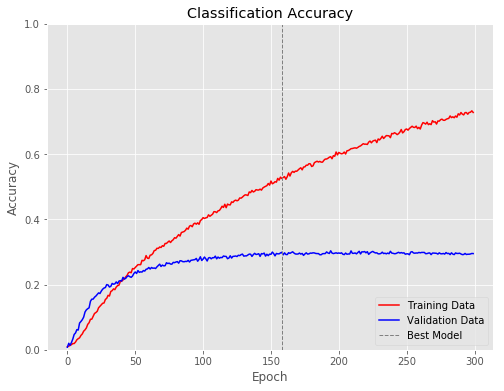

In [42]:
### plot training process

print()
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(training_history['acc'], color = 'red', label = 'Training Data')
ax.plot(training_history['val_acc'], color = 'blue', label = 'Validation Data')
ax.axvline(x=np.argmin(training_history['val_loss']),linewidth=1, linestyle='dashed', label = 'Best Model', color='grey' )
ax.set_ylim(0, 1)
ax.legend(loc = 'lower right')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Classification Accuracy")

plt.show()

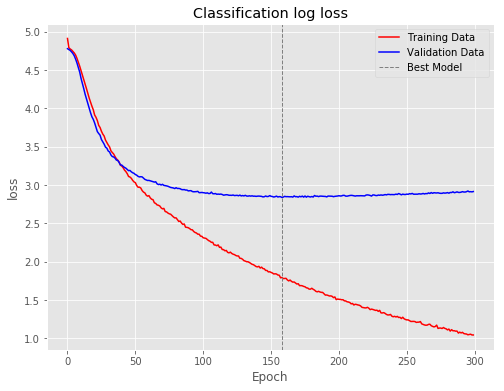

In [43]:
# summarize history for loss
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(training_history['loss'], color = 'red', label = 'Training Data')
ax.plot(training_history['val_loss'], color = 'blue', label = 'Validation Data')
ax.axvline(x=np.argmin(training_history['val_loss']),linewidth=1, linestyle='dashed', label = 'Best Model', color='grey' )
ax.legend(loc = 'best')
ax.set_xlabel("Epoch")
ax.set_ylabel("loss")
ax.set_title("Classification log loss")
plt.show()

### ROC curve for sample class

In [44]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def display_roc_curve(y, predict_y_proba):
   
    fp_rate1, tp_rate1, _ = roc_curve(y, predict_y_proba)
    roc_auc1 = auc(fp_rate1, tp_rate1)

    print()
    plt.figure(figsize = (6, 6))
    plt.title('ROC AUC (Class = 1)')
    
    plt.plot(fp_rate1, tp_rate1, 'b',
    label='AUC = %0.2f'% roc_auc1)
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'r--', lw = 1)
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()

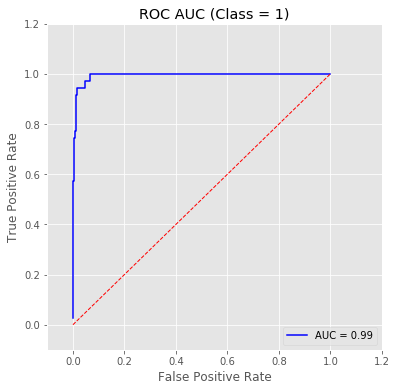

In [45]:
### ROC curve for sample class
class_num = 8
display_roc_curve(y_valid[:, class_num], y_valid_predict_proba[:, class_num])

## 10. CNN Features Learned

The visualization below shows the internal representation of layer five during learning. Clearly the network is learning elementary features such as lines an corners which will be built on to populate higher levels of the model.

#### Layer 5

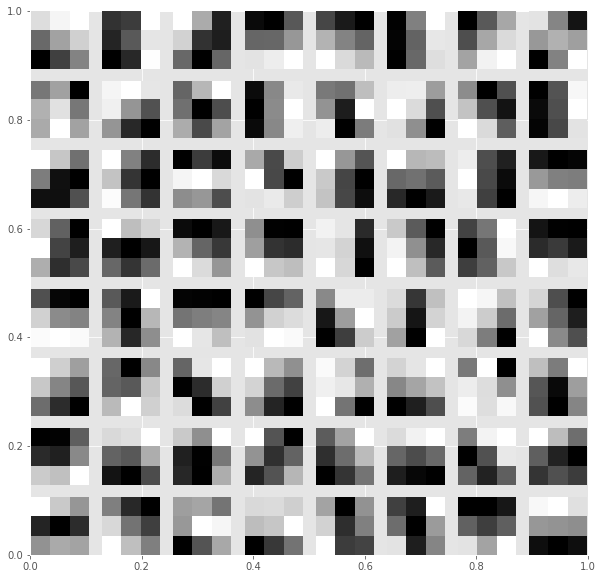

In [46]:
if model_type is 'cnn':
    ;
# get layer weights
layer = model.layers[5]
weights = layer.get_weights()

# set up plot
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)

# populate plot
index = 0
for i in range(8):
    for j in range(8):
        w = weights[0][:,:,0,index]
        w = w.reshape(3,3)
        index += 1
        ax = fig.add_subplot(8,8,index)
        ax.axis('off')
        plt.imshow(w, cmap = 'gray')    

# show plot
plt.show()

## 11. Review Models

### Results
Our CNN model achieved a categorical log loss of 2.84 against validation data and 2.83 against test data (on Kaggle). Validation accuracy was 30%.

### Next steps
With this limited dataset, it proved difficult to avoid overfitting the models, even after applying certain techniques (such as dropout layers) to address this situation.  

We observed a floor with the CNN log loss. Minor gains might potentially be achieved through additional hyperparameter tuning. We tend to think that the the biggest gains would be achieved though sourcing additional training images and implementing further data augmentation. In particular, we would like to explore facial recognition and cropping to improve the richness of our data preprocessing.